In [1]:
from aicsimageio import AICSImage
import os

import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_process_points_and_surfaces as nppas
import vedo
from skimage import measure, transform

import napari
import napari_stress

We need to set some parameters for processing. The parameters and their possible downstream effects on the analysis are explained here:

* `surface_density`: The droplet is represented by vertices on the surface - this parameter controls how dense these vertices will be spread on the surface. Higher density values leads to large computational time, lower density will lead to a more ragged surface and possible holes in the created surfaces.
* `voxel_size_droplet`: The image data of the voxel will be downsampled to this (iostropic) voxel size.

In [2]:
# Config
surface_density = 0.1  # vertices/microns^2
voxel_size_droplet = 2.0  # microns
n_iterations_refinement = 2  # number of trace surface refinement steps
curvature_radius = 20

T = 2  # Number of timeframes to analyze. Set to -1 to analyze all timeframes

Since we can not move all data to the memory, we need to use dask for this:

In [3]:
filename = r'C:\Users\johamuel\Desktop\3-001.czi'
image = AICSImage(filename)

spheroid_raw = image.dask_data[:, 0]
droplet_raw = image.dask_data[:, 1]

droplet_raw

dask.array<getitem, shape=(24, 326, 1600, 1600), dtype=uint16, chunksize=(1, 326, 1600, 1600), chunktype=numpy.ndarray>

In [4]:
scale = np.asarray(image.physical_pixel_sizes)
print('Current voxel sizes: ', scale)

Current voxel sizes:  [0.47708185 0.2289011  0.2289011 ]


In [5]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


## Droplet analysis

Before we look at the spheroid, let's have a look at the droplet. Due to the large array size, we need to downsample the droplet ince we will not need voxel sizes of <1µm.

### Preprocessing

- Downsampling
- Thresholding (simple threshold otsu)
- Surface reconstruction (marching cubes)
- Surface decimation (We don't need all the >100k vertices of the surface do achieve a good representation)

Before we proceed, it makes sense to crop a part of the data which we can reshape to heterotropic voxel size

In [9]:
scale_factor = scale/0.2289011

In [ ]:
# Calculate scaling factors

dropled_downsampled = napari_stress.rescale(spheroid_raw, scale_z = scale_factor[0], scale_y = scale_factor[1], scale_x = scale_factor[2] )

In [8]:
# Binarize and crop the droplet based on its bounding box
droplet_binary = nsbatwm.threshold_otsu(dropled_downsampled)
droplet_labels = napari_stress.frame_by_frame(nsbatwm.label)(droplet_binary)

In [10]:
# Create surface
surface = napari_stress.frame_by_frame(nppas.largest_label_to_surface)(droplet_labels)
surface_layer = viewer.add_surface(surface)

Running surface_from_label: 100%|████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.69it/s]


In [11]:
# Smooth surface
smoothed_surface = napari_stress.frame_by_frame(nppas.filter_smooth_simple)(surface, number_of_iterations=1)
smoothed_surface = napari_stress.smooth_sinc(smoothed_surface)
smoothed_surface_layer = viewer.add_surface(smoothed_surface, name='Smoothed surface')

Running filter_smooth_simple: 100%|██████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.43s/it]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Running smooth_sinc: 100%|███████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.73it/s]


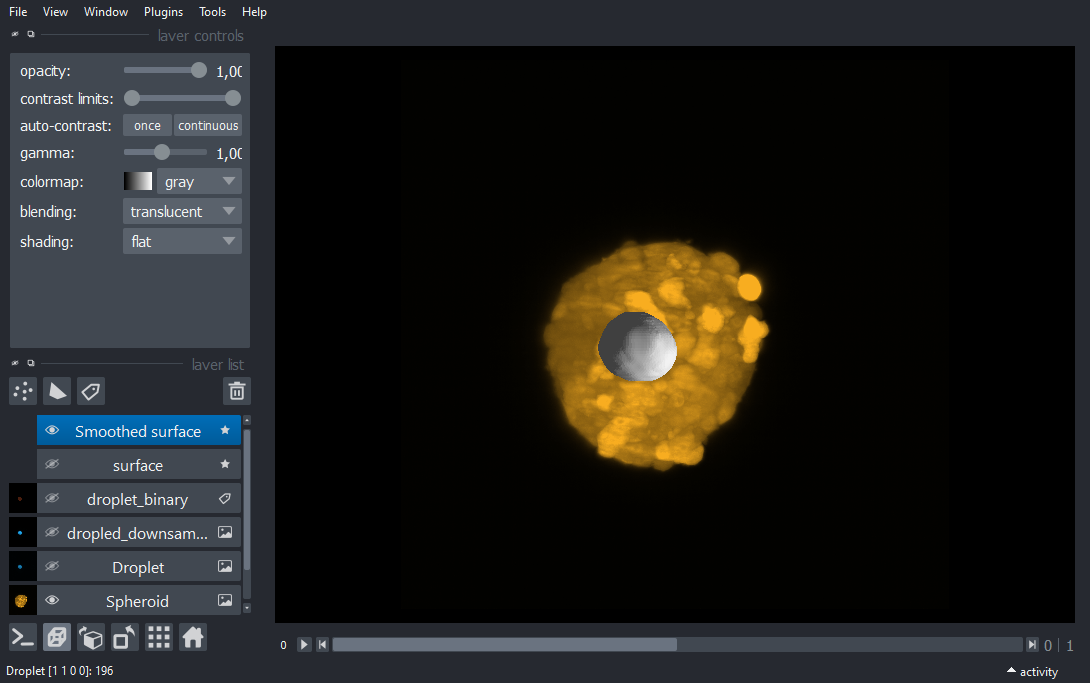

In [ ]:
#droplet_binary_layer.visible = False
#surface_layer.visible = False
#napari.utils.nbscreenshot(viewer, canvas_only=False)

## Surface refinement

In the next step, we will trace-refine the surface, filter the detected points and resample the density of the vertices on the surface to a defined value. In detail:

* Resampling: If the numbers of vertices is above the required number of points for a given surface density, then the surface mesh is decimated to achieve the desired vertex density. If the mesh contains less points than desired, the mesh is interpolated and decimated again, if necessary.
* Trace refinement: Rays are cast along the surface normals at every point. A selected edge detection method is then used to detect the surface of the droplet
* Filtering: The edge-detection method returns an error. Points with fit errors above Q75 + 1.5 x IQR (Q75: 75% percentile, ICQ: inter-quartil range) are classified as outliers and removed from the list of points
* Surface reconstruction: Lastly, we recreate a surface from the remaining points and resample the existing points on the surface to fill possible holes.

In [13]:
# Surface resampling
adjusted_surface = napari_stress.adjust_surface_density(smoothed_surface, density_target=surface_density)

density_adjusted_surface_layer = viewer.add_surface(adjusted_surface, name='density-adjusted surface')
density_adjusted_points_layer = viewer.add_points(adjusted_surface[0], size=1, name='density-adjusted points')

Running adjust_surface_density: 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.83it/s]


In [14]:
print('Number of vertices before adjustment:', smoothed_surface[0].shape[0])
print('Number of vertices after adjustment:', adjusted_surface[0].shape[0])

Number of vertices before adjustment: 5828
Number of vertices after adjustment: 1648


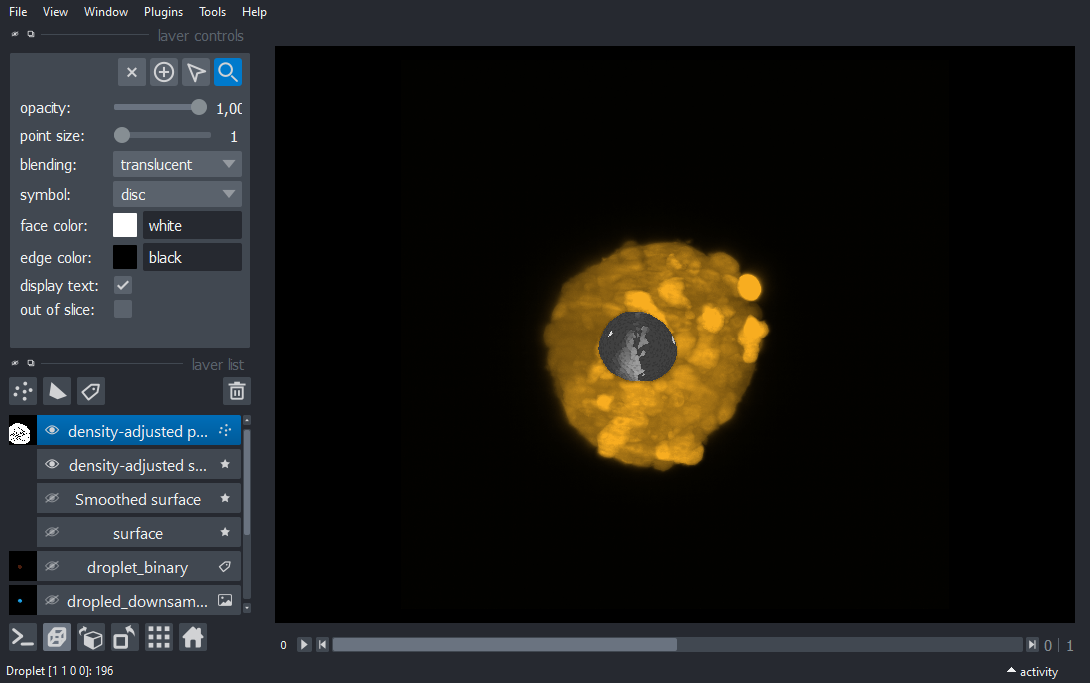

In [15]:
#smoothed_surface_layer.visible = False
#napari.utils.nbscreenshot(viewer, canvas_only=False)

In [19]:
resampled_points = adjusted_surface[0]  # get points from density-adjusted surface

for i in range(n_iterations_refinement):
    traced_points = napari_stress.trace_refinement_of_surface(dropled_downsampled,
                                                              resampled_points,
                                                              trace_length=15.0,
                                                              sampling_distance=1,
                                                              scale=np.asarray([voxel_size_droplet] * 3),
                                                              show_progress=False,
                                                              selected_fit_type='fancy',
                                                              remove_outliers=True,
                                                              interquartile_factor=3.0)
    print('Number of removed vertices: ', resampled_points.shape[0] - traced_points.shape[0])
    resampled_points = napari_stress.resample_points(traced_points)
    
traced_pts_layer = viewer.add_points(resampled_points, face_color='cyan', size=1.0, name='Traced points')


Running trace_refinement_of_surface: 100%|███████████████████████████████████████████████| 2/2 [00:03<00:00,  1.75s/it]


Number of removed vertices:  18


Running trace_refinement_of_surface: 100%|███████████████████████████████████████████████| 2/2 [00:03<00:00,  1.58s/it]


Number of removed vertices:  8


Running resample_points: 100%|███████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.14it/s]


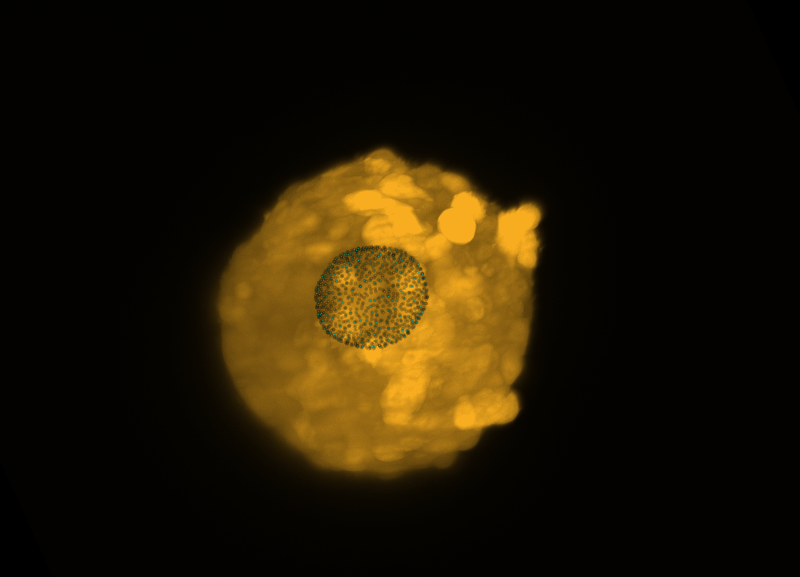

In [20]:
#smoothed_surface_layer.visible = False
#density_adjusted_surface_layer.visible = False
#density_adjusted_points_layer.visible = False
#napari.utils.nbscreenshot(viewer, canvas_only=True)

Running simplify_quadric_decimation: 100%|███████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


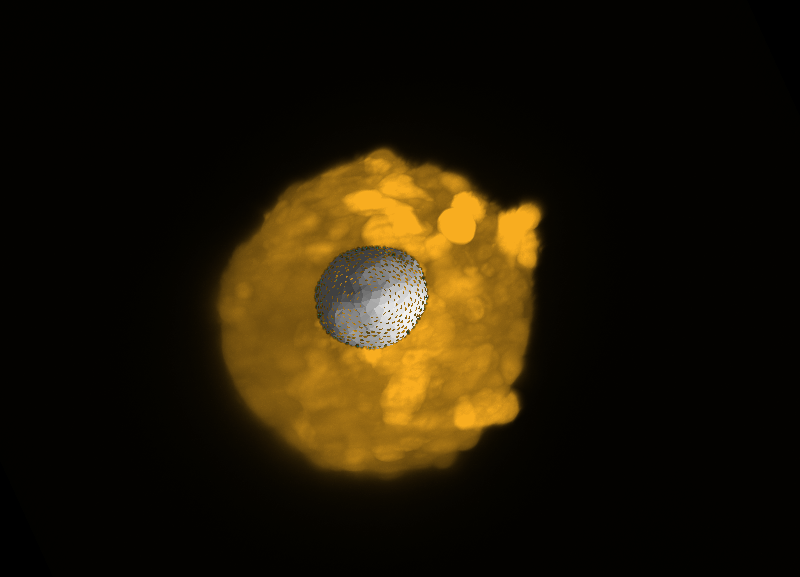

In [21]:
# Surface reconstruction
#traced_surface = napari_stress.reconstruct_surface(resampled_points)
#traced_surface = napari_stress.frame_by_frame(nppas.simplify_quadric_decimation)(traced_surface, target_number_of_triangles=1000)
#viewer.add_surface(traced_surface)
#napari.utils.nbscreenshot(viewer, canvas_only=True)

# Curvature

Lastly, we measure the curvature of the object and encode its value in the surface color:

In [24]:
result = napari_stress.frame_by_frame(nppas.add_spherefitted_curvature, progress_bar=True)(traced_surface, radius=curvature_radius)
curvature = result[0]
fit_residues = result[1]

Running add_spherefitted_curvature: 100%|███████████████████████████████████████████████| 2/2 [09:23<00:00, 281.60s/it]


In [25]:
curvature_layer = viewer.add_surface(curvature[0], **curvature[1])
fit_residue_layer = viewer.add_surface(fit_residues[0], **fit_residues[1])

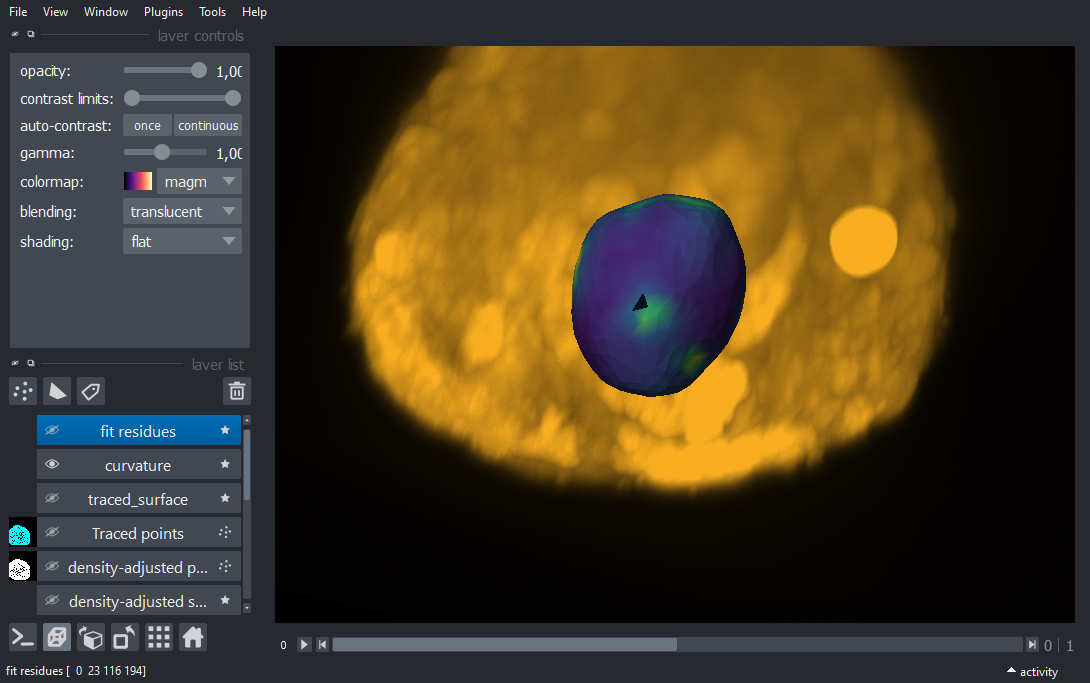

In [26]:
density_adjusted_surface_layer.visible = False
density_adjusted_points_layer.visible = False
curvature_layer.visible = True
fit_residue_layer.visible = False
traced_pts_layer.visible = False
napari.utils.nbscreenshot(viewer)

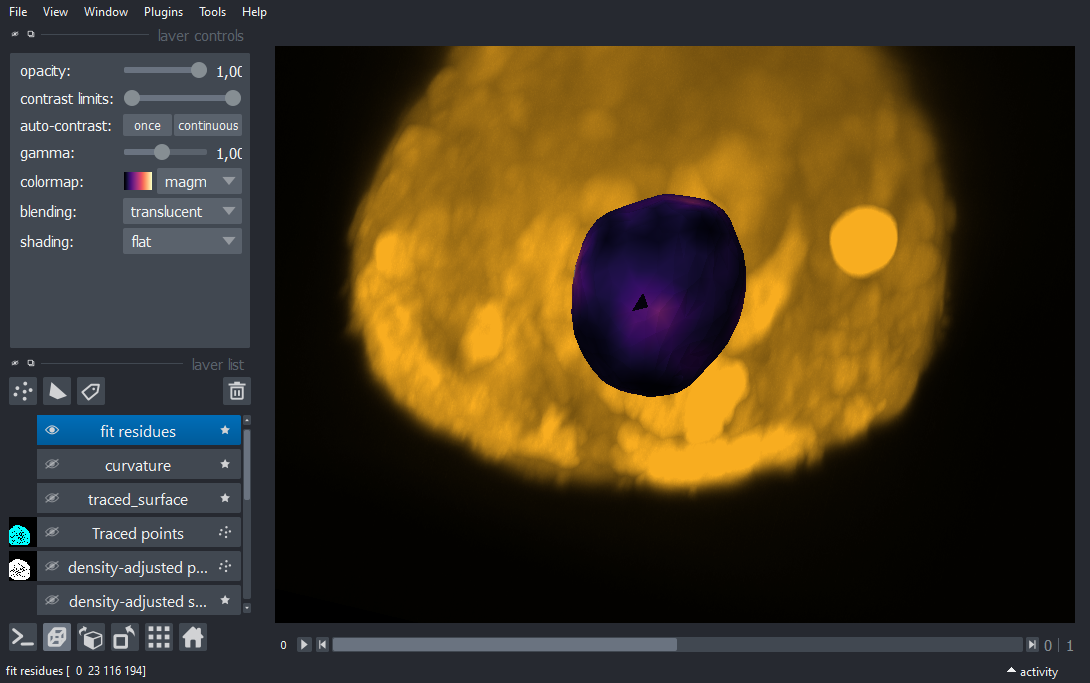

In [ ]:
curvature_layer.visible = False
fit_residue_layer.visible = True
traced_pts_layer.visible = False
napari.utils.nbscreenshot(viewer)